# **Cross-Validation Training on Dataset 02 for Binary SQL Injection Detection**

**We implements and compares three machine learning approaches ( Naive Bayes, SVM, Random Forest) for detecting SQL injection attacks in query strings. The implementation uses a balanced dataset with 18,000 training samples and 2,000 testing samples, processed using TF-IDF vectorization with n-gram features. Each model undergoes hyperparameter optimization via 5-fold cross-validation with GridSearchCV. Performance results demonstrate that Naive Bayes achieves the highest overall accuracy (69%) with balanced precision-recall trade-off (F1=0.76 for malicious queries), while SVM excels at detecting malicious queries with 97.5% recall but suffers from high false positives .**

# **Install KaggleHub with Pandas Support**

In [ ]:
 !pip install kagglehub[pandas-datasets]

## **Load SQL Injection Dataset from Kaggle**

In [ ]:

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# The file path should include the file name and extension, e.g., 'Modified_SQL_Dataset.csv'
file_path = "Modified_SQL_Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sajid576/sql-injection-dataset",
  file_path,

)

print("First 5 records:", df.head())

/tmp/ipykernel_36/2492273489.py:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                                Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1


# **Download SQL Injection Dataset from Kaggle**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sajid576/sql-injection-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/sql-injection-dataset


### 📊 Dataset Overview

- **Training Dataset**:Custom SQL Injection Dataset  
  - Total Samples: **18,000**
  - Class Distribution:
    - SQL Injection (Malicious): **9,000**
    - Normal (Non-Malicious): **9,000**

- **Testing Dataset**:[SQL Injection Dataset](https://www.kaggle.com/datasets/sajid576/sql-injection-dataset/data)
  - Total Samples: **2,000**
  - Class Distribution:
    - SQL Injection (Malicious): **1,000**
    - Normal (Non-Malicious): **1,000**


# **Random Forest**

/tmp/ipykernel_36/914756267.py:14: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")  # Custom dataset for training


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV F1 Score: 0.9996688452175393
Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Test Accuracy: 0.4375
Classification Report:
               precision    recall  f1-score   support

           0     0.1118    0.0180    0.0310      1000
           1     0.4660    0.8570    0.6037      1000

    accuracy                         0.4375      2000
   macro avg     0.2889    0.4375    0.3174      2000
weighted avg     0.2889    0.4375    0.3174      2000

Confusion Matrix:
 [[ 18 982]
 [143 857]]


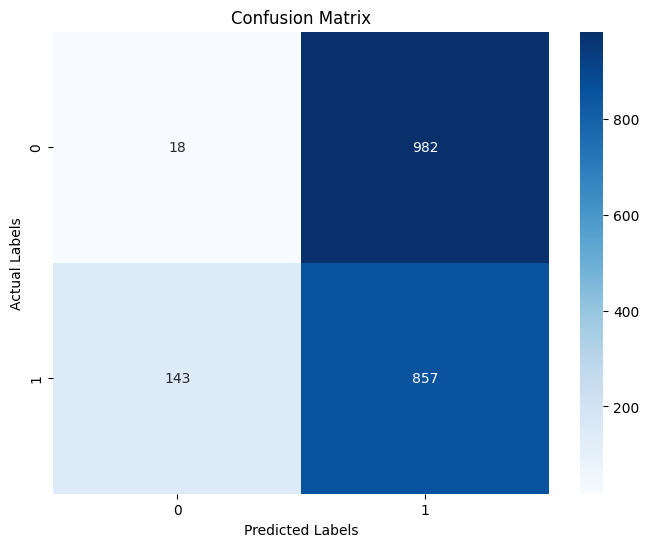

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets with the revised order:
df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")
df_test  = pd.read_csv("/kaggle/input/sql-injection-dataset/Modified_SQL_Dataset.csv")

# 2. Drop missing values from the relevant columns:
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['Query', 'Label'], inplace=True)

# 3. Rename columns to a common scheme "text" for the query and "label" for the class:
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'Query': 'text', 'Label': 'label'}, inplace=True)

# 4. Map labels to 0/1 according to each dataset's format:
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

# For the Kaggle dataset (testing), convert to numeric:
df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Sample exactly 18,000 train samples (9k per class) and 2,000 test samples (1k per class)
df_train_0 = df_train[df_train.label == 0].sample(9000, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(9000, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(1000, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(1000, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Split into features and labels for model training and evaluation
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test   = df_test_bal['text'], df_test_bal['label']

# 7. Build a machine learning pipeline: TF-IDF vectorizer followed by an XGBoost classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20_000)),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

# 8. Define a hyperparameter grid for XGBoost tuning via GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.01, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}

# 9. Define the cross‐validation strategy; here 5-fold CV is used.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. Create the GridSearchCV object to find the best hyperparameters based on the F1 score
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output the best CV F1 score and the best hyperparameters found
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate the best model on the balanced test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 14. Plot the confusion matrix using seaborn for a visual overview
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


# **Naive Bayes**

/tmp/ipykernel_36/172145471.py:14: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")  # Custom dataset for training


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Test Accuracy: 0.6900
Classification Report:
               precision    recall  f1-score   support

           0     0.9204    0.4160    0.5730      1000
           1     0.6227    0.9640    0.7567      1000

    accuracy                         0.6900      2000
   macro avg     0.7715    0.6900    0.6648      2000
weighted avg     0.7715    0.6900    0.6648      2000

Confusion Matrix:
 [[416 584]
 [ 36 964]]


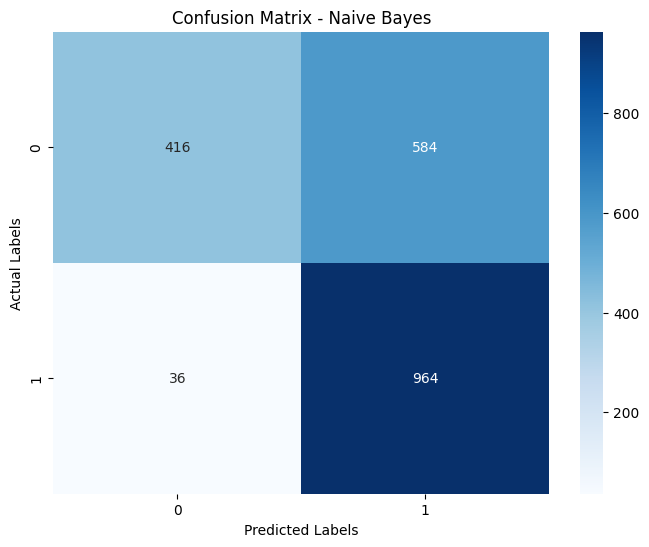

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets with the revised order:
df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")  # Custom dataset for training
df_test  = pd.read_csv("/kaggle/input/sql-injection-dataset/Modified_SQL_Dataset.csv")  # Kaggle dataset for testing

# 2. Drop missing values from the relevant columns:
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['Query', 'Label'], inplace=True)

# 3. Rename columns to a common scheme "text" for the query and "label" for the class:
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'Query': 'text', 'Label': 'label'}, inplace=True)

# 4. Map labels to 0/1 according to each dataset's format:
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

# For the Kaggle dataset (testing), convert to numeric:
df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Sample exactly 18,000 train samples (9k per class) and 2,000 test samples (1k per class)
df_train_0 = df_train[df_train.label == 0].sample(9000, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(9000, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(1000, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(1000, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Split into features and labels for model training and evaluation
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test   = df_test_bal['text'], df_test_bal['label']

# 7. Build a machine learning pipeline: TF-IDF vectorizer followed by a Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20_000)),
    ('clf', MultinomialNB())  # Using MultinomialNB which is suitable for text classification
])

# 8. Define a hyperparameter grid for Naive Bayes tuning via GridSearchCV
param_grid = {
    'tfidf__max_features': [10_000, 20_000, 30_000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
    'clf__fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# 9. Define the cross‐validation strategy; here 5-fold CV is used.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. Create the GridSearchCV object to find the best hyperparameters based on the F1 score
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output the best CV F1 score and the best hyperparameters found
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate the best model on the balanced test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 14. Plot the confusion matrix using seaborn for a visual overview
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# **SVC**

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Test Accuracy: 0.5155
Classification Report:
               precision    recall  f1-score   support

           0     0.6914    0.0560    0.1036      1000
           1     0.5081    0.9750    0.6680      1000

    accuracy                         0.5155      2000
   macro avg     0.5997    0.5155    0.3858      2000
weighted avg     0.5997    0.5155    0.3858      2000

Confusion Matrix:
 [[ 56 944]
 [ 25 975]]


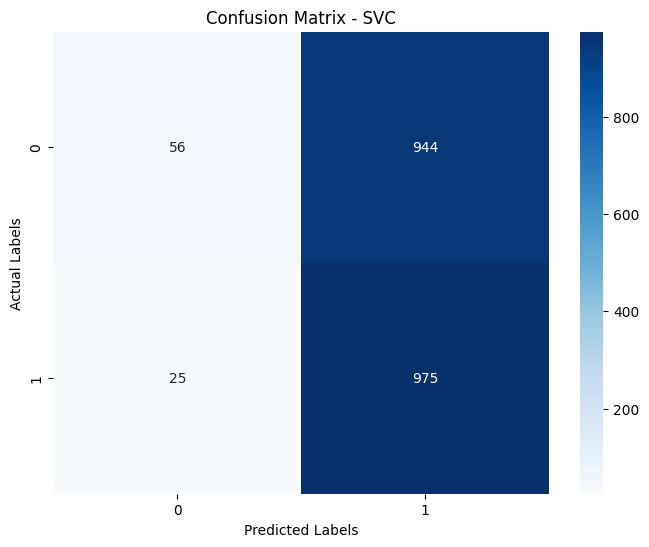

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets with low_memory=False to suppress DtypeWarning
df_train = pd.read_csv(
    "/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv",
    low_memory=False,
    dtype={'sql_query': str, 'vulnerability_status': str}
)

df_test = pd.read_csv(
    "/kaggle/input/sql-injection-dataset/Modified_SQL_Dataset.csv",
    low_memory=False,
    dtype={'Query': str, 'Label': str}
)

# 2. Drop missing values from the relevant columns
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['Query', 'Label'], inplace=True)

# 3. Rename columns to a common scheme
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'Query': 'text', 'Label': 'label'}, inplace=True)

# 4. Map labels to 0/1
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

# Kaggle dataset (test) -> numeric
df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Balanced sampling (safe, even if fewer rows exist)
train_min = min(df_train['label'].value_counts().min(), 9000)
test_min = min(df_test['label'].value_counts().min(), 1000)

df_train_0 = df_train[df_train.label == 0].sample(train_min, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(train_min, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(test_min, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(test_min, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Split into features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test = df_test_bal['text'], df_test_bal['label']

# 7. Pipeline: TF-IDF + SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20_000)),
    ('clf', SVC(random_state=42))
])

# 8. Hyperparameter grid
param_grid = {
    'tfidf__max_features': [10_000, 20_000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

# 9. Cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Best CV score & params
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 14. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - SVC')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# 15. Compare with a simple linear SVC
simple_svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20_000)),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])
